In [167]:
import pandas as pd
import sqlalchemy
import math
import os, sys, copy, random, pickle, cv2
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

sys.path.append("../")

%load_ext autoreload
%autoreload 2

from modules.ControlTracking import TrackFactory
from modules.ControlDisplay import Display
from modules.Interproc import DBInterface, GuiviewState

from modules.AnalysisHelpers import ( 
         exploreImgs, buildImgComparisonData, subprocEval,
        subprocBatchOutput, cvtPlot)

from modules.EvalHelpers import EvalTracker, EvalDataset
from modules.ControlEval import EvalFactory
from modules.DataSchemas import ScoreSchema
from modules.EvalHelpers import OutcomeData, DFHelper

from modules.EvalHelpers import AggEval, DFHelper

from modules.EvalSuite import EvalSuite, CmpAlgoReport

from IPython.display import display

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Here we explore how to use CmpAlogReport to show differences in whole-video performance, and individual frame diff for in-depth comparison.

Note: this was done on algoenum=0 vs algoenum=2 where algoenum=0 was faulty and not always resetting it's currentTrackScore when it failed to isolate the ball. We'll re-run this analysis in eval-report-3 with the error corrected.
That does show you the power of biz-logic / priors in guessing where the ball may be.

In [160]:
#Load outcome data, pre-eval'd via command-line and saved to book-data

db_path = 'data/misc/books/eval_report_2/'

outcome_0 = OutcomeData(dbPathFn = db_path + 'algo_0.db')
outcome_2 = OutcomeData(dbPathFn = db_path + 'algo_2.db')

In [161]:
cmpA = CmpAlgoReport(benchmark_outcome_data = outcome_0.getOutcome(), 
                     current_outcome_data = outcome_2.getOutcome()
                    )

,improvements,deprovements,sames
checkTrackSuccess,0.000,0.000,345.000


,improvements,deprovements,sames
calcBaselineBallUnitsAway,7,3,9
checkBothContainsOther,3,0,16
checkTrackSuccess,0,0,19
distanceFromBaseline,7,3,9


,diff,current,benchmark
,mean,mean,mean
agg_checkTrackSuccess,0.000,1.000,1.000
agg_calcBaselineBallUnitsAway,0.053,-0.407,-0.460
agg_checkBothContainsOther,0.158,0.579,0.421
agg_distanceFromBaseline,0.366,-5.125,-5.491


diff        current          benchmark  \
                                   mean      n    mean        n      mean   
fagg_less_than_20_pix_balls_away  0.066  0.000  -0.467   16.000    -0.533   
fagg_less_than_30_pix_success     0.000  0.000   1.000  310.000     1.000   

                                           
                                        n  
fagg_less_than_20_pix_balls_away   16.000  
fagg_less_than_30_pix_success     310.000

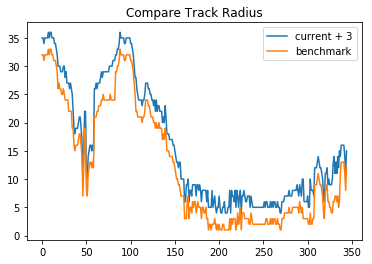

In [162]:
cmpA.report1()

In [163]:
ret = cmpA.largestDiscrepancy(distanceFromBaseline=0)
display(ret[:6])
foi = [int(x) for x in ret.index]
print foi[:5]

("Unknown format code 'f' for object of type 'str'", u'occurred at index (current, checkBaselineInsideTrack)')


,diff,current,benchmark
,distanceFromBaseline,distanceFromBaseline,distanceFromBaseline
295,4.434,-5.000,-9.434
78,-2.828,-4.243,-1.414
215,2.385,-3.000,-5.385
187,1.143,-4.243,-5.385
195,1.000,-3.000,-4.000
307,0.630,-10.000,-10.630


[295, 78, 215, 187, 195]


In [218]:
ret = cmpA.largestDiscrepancy(calcBaselineBallUnitsAway=0)
display(ret[:6])
foi = [int(x) for x in ret.index]
print foi[:5]

,diff,current,benchmark
,calcBaselineBallUnitsAway,calcBaselineBallUnitsAway,calcBaselineBallUnitsAway
295,0.443,-0.500,-0.943
215,0.298,-0.375,-0.673
187,0.143,-0.530,-0.673
195,0.125,-0.375,-0.500
78,-0.057,-0.085,-0.028
307,0.045,-0.714,-0.759


[295, 215, 187, 195, 78]


### View Discrepancy Images

In [176]:
from modules.Interproc import GuiviewState

In [219]:
vid_fn = 'data/proc/tmp/dec14/output5.proc1.proc1.avi'
listGS = subprocBatchOutput(vid_fn, batch_list = foi[:6])

In [221]:
print 'orginal order: '
print [gs.frameCounter for gs in listGS]

# order by discrepancy table
def discrepancyLookup(frame_counter):
    try:
        return foi.index(frame_counter)
    except:
        return 0

listGS.sort(key=lambda item: discrepancyLookup(item.frameCounter), reverse = False)

print 'new order: '
print [gs.frameCounter for gs in listGS]

orginal order: 
[307, 78, 195, 187, 215, 295]
new order: 
[295, 215, 187, 195, 78, 307]


In [179]:
gs = listGS[1]

#### Build Tracking Objects for Comparison

In [180]:
from modules.AnalysisHelpers import applyTracker, multiPlot
from modules.ControlTracking import TrackFactory

In [114]:
tracker = TrackFactory

In [181]:
algo_nums = [0,2]

d_trackers = {}
for algo_num in algo_nums:
    _track = TrackFactory(on=True)
    _track.setInit(ballColor='green')
    _track.setAlgoEnum(algo_num)
    d_trackers[str(algo_num)] = _track
    
for elem in d_trackers.items():
    print elem[0]
    print elem[1].getTrackParams()
    
# why do they have same params?

0
{'thresh_hi': (64, 255, 255), 'threshes': [((29, 86, 6), (64, 255, 255)), ((20, 60, 6), (40, 255, 255))], 'thresh_lo': (29, 86, 6), 'tracking_blur': 1, 'repair_iterations': 1}
2
{'thresh_hi': (64, 255, 255), 'threshes': [((29, 86, 6), (64, 255, 255)), ((20, 60, 6), (40, 255, 255))], 'thresh_lo': (29, 86, 6), 'tracking_blur': 1, 'repair_iterations': 1}


In [122]:
track0 = d_trackers['0']
track2 = d_trackers['2']

In [124]:
print track0.tp_trackAlgoEnum, track2.tp_trackAlgoEnum

0 2


### Plotting

In [175]:
from modules.Interproc import GuiviewState

In [171]:
from modules.AnalysisHelpers import roiSelectScoreWindow

(14, 13, 3)


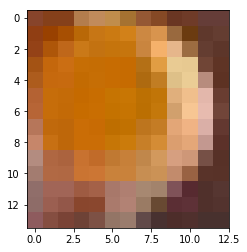

(336, 312, 3)


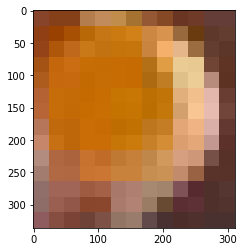

In [242]:
#dealing with how to get cropped-regions, e.g. the scoreWindow
#in their original pixel size and shape

ind = 0
gs = listGS[ind]
gs.initDisplay()

#non-resize image
score_img_origsize = roiSelectScoreWindow(gs)

print score_img_origsize.shape
cvtPlot(score_img_origsize)
plt.show()

#resize image
score_img_newsize = gs.getScoreWindow()

print score_img_newsize.shape
cvtPlot(score_img_newsize)
plt.show()

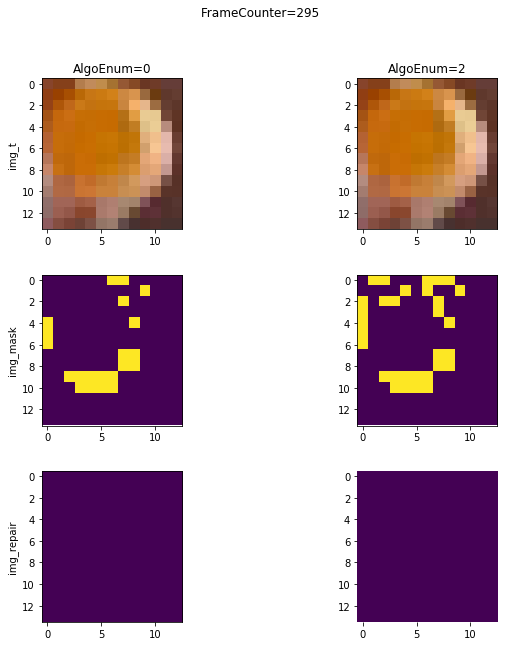

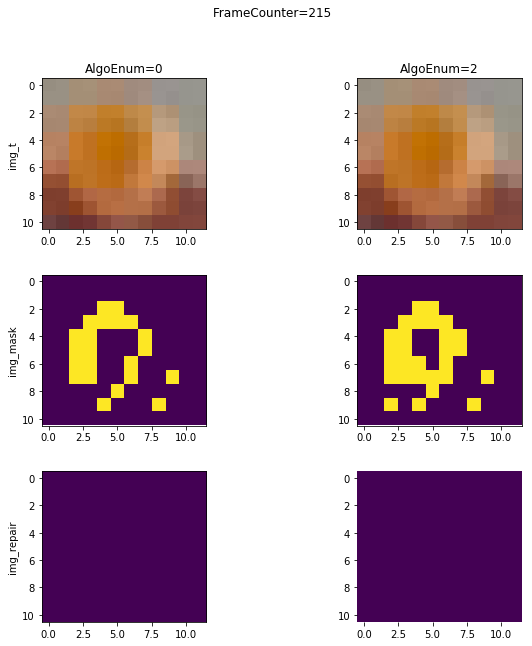

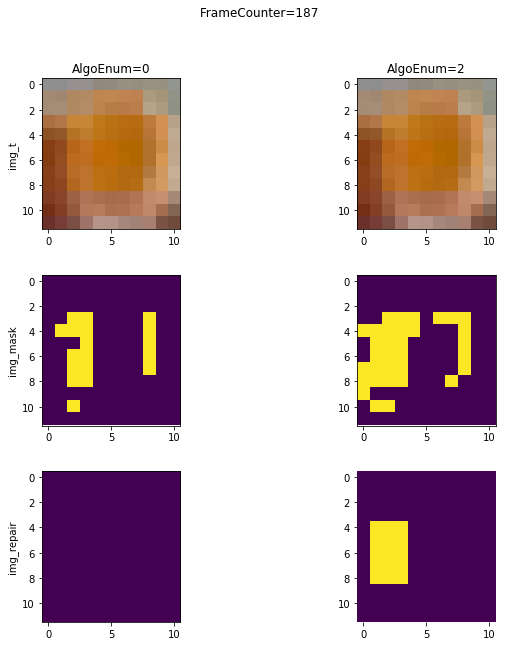

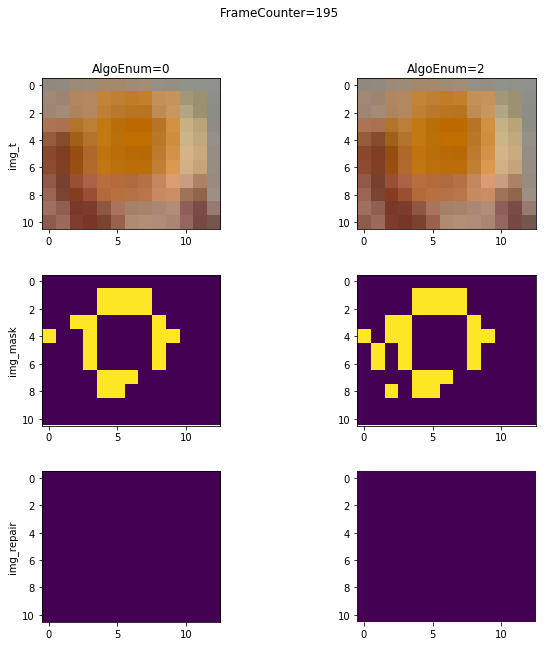

In [240]:
# build my first comparison plot

algo_enums = [0,2]
frame_inds = [0,1,2,3]

for frame_ind in frame_inds:
    
    plotData = []
    listFrameTitles = []
    listTransformTitles = []

    for algo_enum in algo_enums:

        _tracker = d_trackers[str(algo_enum)]

        data = applyTracker([listGS[frame_ind]], _tracker, roiSelectScoreWindow)

        plotData.append(copy.deepcopy(data['listPlts'][0]))

        listFrameTitles.append( 'AlgoEnum=' +
                               str(_tracker.tp_trackAlgoEnum)
                              )

        #only on first loop
        #if algo_enum == algo_enums[0]:
        listTransformTitles = copy.copy(data['listTransformTitles'])

    multiPlot( list_list_imgs = plotData
              ,input_frame_titles = listFrameTitles
              ,input_transform_titles = listTransformTitles
              ,input_figure_title = ('FrameCounter=' + 
                                     str(listGS[frame_ind].frameCounter)
                                    )
             )

So why does img_repair not have any object present in most plots?
B/c the found region is outside the score window?

### Look at if EvalMetrics are correct for these frames

In [243]:
for gs in listGS:
    gs.initDisplay()

In [301]:
track0.tp_trackAlgoEnum, track2.tp_trackAlgoEnum

(0, 2)

In [304]:
algo_nums = [0,1,2]

d_trackers = {}
for algo_num in algo_nums:
    _track = TrackFactory(on=True)
    _track.setInit(ballColor='green')
    _track.setAlgoEnum(algo_num)
    d_trackers[str(algo_num)] = _track
    
for elem in d_trackers.items():
    print elem[0]
    print elem[1].getTrackParams()
    
track0 = d_trackers['0']
track2 = d_trackers['2']

0
{'thresh_hi': (64, 255, 255), 'threshes': [((29, 86, 6), (64, 255, 255)), ((20, 60, 6), (40, 255, 255))], 'thresh_lo': (29, 86, 6), 'tracking_blur': 1, 'repair_iterations': 1}
2
{'thresh_hi': (64, 255, 255), 'threshes': [((29, 86, 6), (64, 255, 255)), ((20, 60, 6), (40, 255, 255))], 'thresh_lo': (29, 86, 6), 'tracking_blur': 1, 'repair_iterations': 1}


In [306]:
#look at an two diff tracker's results to one particular frame

gs = listGS[2]

frame_gs = gs.getOrigFrame()

track0.setFrame(frame_gs.copy())
track2.setFrame(frame_gs.copy())

track_log = track0.trackFrame(b_log=True)
track_log2 = track2.trackFrame(b_log=True)

print track_log['xy'], track_log2['xy']
print track_log['radius'], track_log2['radius']

(401.0, 0.5) (362.0, 275.0)
1.11813402176 2.23616790771


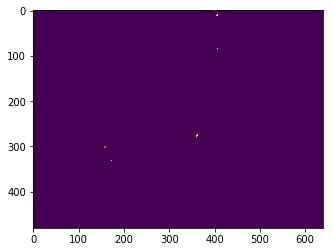

In [308]:
cvtPlot(track_log2['img_repair'])

In [310]:
cvtPlot(track_log['img_repair'])

KeyError: 'img_repair'

In [266]:
#what is the true inputScore for this frame?
inputScore = gs.displayInputScore
score = None
if inputScore is not None:
    score = inputScore.get('0', {}).get('data', None)
score

[361, 270, 9, 10]

In [269]:
print 'my frame_index= ' + str(gs.frameCounter)

ret = cmpA.largestDiscrepancy(calcBaselineBallUnitsAway=0)
display(ret[:6])
foi = [int(x) for x in ret.index]
print foi[:5]

my frame_index= 187


,diff,current,benchmark
,calcBaselineBallUnitsAway,calcBaselineBallUnitsAway,calcBaselineBallUnitsAway
295,0.443,-0.500,-0.943
215,0.298,-0.375,-0.673
187,0.143,-0.530,-0.673
195,0.125,-0.375,-0.500
78,-0.057,-0.085,-0.028
307,0.045,-0.714,-0.759


[295, 215, 187, 195, 78]


So how was benchmark -0.673 ball units away when the distance was clearly much greater?

##### Here, we see the calc method does appear to work isolated from a table

In [ ]:
gs = listGS[2]

In [283]:
b_algo_0 = True

baseline_score = gs.displayInputScore
ev = EvalTracker()
ev.setBaselineScore(baseline_score)
print 'baseline score: ' +  str(baseline_score)

_tracklog = track_log if b_algo_0 else track_log2
print 'algo num: ' + ('0' if b_algo_0 else '2')

ss = ScoreSchema()
ss.addCircle(_tracklog['scoreCircle'])
print 'track_score: ' + str(ss.getAll())

dist = ev.distanceFromBaseline(ss.getAll())

print 'distance calcd: ' + str(dist)

baseline score: {u'0': {u'data': [361, 270, 9, 10], u'type': u'circle'}}
algo num: 0
track_score: {'0': {'type': 'circle', 'data': [399, 0, 2, 2]}}
distance calcd: -276.226356454


In [284]:
b_algo_0 = False

baseline_score = gs.displayInputScore
ev = EvalTracker()
ev.setBaselineScore(baseline_score)
print 'baseline score: ' +  str(baseline_score)

_tracklog = track_log if b_algo_0 else track_log2
print 'algo num: ' + ('0' if b_algo_0 else '2')

ss = ScoreSchema()
ss.addCircle(_tracklog['scoreCircle'])
print 'track_score: ' + str(ss.getAll())

dist = ev.distanceFromBaseline(ss.getAll())

print 'distance calcd: ' + str(dist)

baseline score: {u'0': {u'data': [361, 270, 9, 10], u'type': u'circle'}}
algo num: 2
track_score: {'0': {'type': 'circle', 'data': [359, 272, 4, 4]}}
distance calcd: -4.12310562562


##### Here, we see for frame187, distanceFromBaseline is -5.386 not -276.22, why?

In [285]:
ret = cmpA.largestDiscrepancy(distanceFromBaseline=0)
display(ret[:6])
foi = [int(x) for x in ret.index]
print foi[:5]

,diff,current,benchmark
,distanceFromBaseline,distanceFromBaseline,distanceFromBaseline
295,4.434,-5.000,-9.434
78,-2.828,-4.243,-1.414
215,2.385,-3.000,-5.385
187,1.143,-4.243,-5.385
195,1.000,-3.000,-4.000
307,0.630,-10.000,-10.630


[295, 78, 215, 187, 195]


In [287]:
cmpA.benchmark.evalDfh.setRowsRequested(s_cmd='inputframes')
cmpA.benchmark.evalDfh.getDatasetDisplay()

,calc Baseline Ball Units Away,check Both Contains Other,distance From Baseline,check Track Success,prop Track Radius,check Baseline Inside Track,check Either Contains Other,check Track Inside Baseline,check Track Inside Baseline Rect,compare Radii,prop Baseline Radius
0,-0.04,True,-2,True,32,True,True,True,False,6,26.0
9,-0.14,True,-7,True,33,True,True,True,False,7,26.0
78,-0.03,True,-1,True,24,True,True,True,False,-1,25.0
116,-0.12,True,-4,True,22,True,True,True,False,3,19.0
136,-0.14,True,-4,True,17,True,True,True,False,2,15.0
176,-0.45,True,-5,True,6,True,True,True,False,0,6.0
187,-0.67,False,-5,True,3,False,False,False,False,-1,4.0
194,-0.75,False,-6,True,2,False,False,False,False,-2,4.0
195,-0.50,False,-4,True,3,False,False,False,False,-1,4.0
201,-0.52,False,-4,True,1,False,False,False,False,-3,4.0


A lot of metrics appear wrong here: propTrackRadius should be 4 not 3 for frame187

In [292]:
cmpA.benchmark.outcomeDfh.setRowsRequested(s_cmd='inputframes')
cmpA.benchmark.outcomeDfh.getDatasetDisplay()[6:7]

,index,input _data0 _0,input _data0 _1,input _data0 _2,input _data0 _3,input _data1 _0,input _data1 _1,input _data1 _2,input _data1 _3,input _data2 _0,...,track _data3 _2,track _data3 _3,track _obj _exists _0,track _obj _exists _1,track _obj _exists _2,track _obj _exists _3,track _obj _type _0,track _obj _type _1,track _obj _type _2,track _obj _type _3
187,187,361.0,NaN,None,None,270.0,NaN,None,None,9.0,...,None,None,True,None,None,None,circle,None,None,None


In [293]:
gs.displayInputScore

{u'0': {u'data': [361, 270, 9, 10], u'type': u'circle'}}

In [294]:
cmpA.benchmark.outcomeDfh.getDatasetDisplay()[6:7].T

,187
index\n,187
input\n_data0\n_0\n,361
input\n_data0\n_1\n,NaN
input\n_data0\n_2\n,None
input\n_data0\n_3\n,None
input\n_data1\n_0\n,270
input\n_data1\n_1\n,NaN
input\n_data1\n_2\n,None
input\n_data1\n_3\n,None
input\n_data2\n_0\n,9


it appears the actual tracking score is (357, 270, 7, 7)

### Conclusion:

It appears that Algo=0 is faulty with resetting currentTrackScore and should not be evaluated here.

In [297]:
cmpA.benchmark.outcomeDfh.rows_requested = None
cmpA.benchmark.outcomeDfh.df[180:190].T

,180,181,182,183,184,185,186,187,188,189
index,180,181,182,183,184,185,186,187,188,189
input_data0_0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,361,NaN,NaN
input_data0_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
input_data0_2,None,None,None,None,None,None,None,None,None,None
input_data0_3,None,None,None,None,None,None,None,None,None,None
input_data1_0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,270,NaN,NaN
input_data1_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
input_data1_2,None,None,None,None,None,None,None,None,None,None
input_data1_3,None,None,None,None,None,None,None,None,None,None
input_data2_0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,NaN,NaN


### ScratchPad

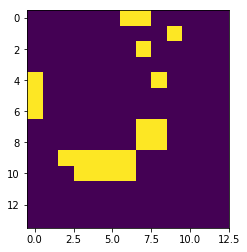

In [241]:
#How to get a track_log on a individual frame, individual tracker
track0.setFrame(score_img_origsize)
track_log = track0.trackFrame(b_log=True)
cvtPlot(track_log['img_mask'])

### Build Tests

In [58]:
df_0 = outcome_0.outcomeData
df_2 = outcome_2.outcomeData

In [60]:
test_path = '../data/test/evalsuite/largestDiscrepancy/'

In [61]:
df_0.to_pickle(test_path + 'outcome_0.pickle')
df_2.to_pickle(test_path + 'outcome_2.pickle')

In [84]:
from modules.EvalSuite import CmpAlgoReport

In [98]:
cbco_improvement.index[:5]

Int64Index([215, 324, 195, 0, 308], dtype='int64')

In [108]:
# load input data
test_path = '../data/test/evalsuite/largestDiscrepancy/'
input_benchmark = pd.read_pickle(test_path + 'outcome_0.pickle')
input_current = pd.read_pickle(test_path + 'outcome_2.pickle')

cmpA = CmpAlgoReport()
cmpA.loadBenchmark(input_benchmark) 
cmpA.loadCurrent(input_current) 

cts_improvement = cmpA.largestDiscrepancy(checkTrackSuccess=1)
cts_deprovement = cmpA.largestDiscrepancy(checkTrackSuccess=-1)
cts_absvalue = cmpA.largestDiscrepancy(checkTrackSuccess=0)

cbco_improvement = cmpA.largestDiscrepancy(checkBothContainsOther=1, max_n=30)
cbco_deprovement = cmpA.largestDiscrepancy(checkBothContainsOther=-1, max_n=30)
cbco_absvalue = cmpA.largestDiscrepancy(checkBothContainsOther=0, max_n=30)

assert [int(x) for x in cbco_improvement.index][:4] == [215, 324, 195, 0 ]
assert [int(x) for x in cbco_deprovement.index][:4] == [0, 308, 307, 295]
assert [int(x) for x in cbco_improvement.index][:4] == [215, 324, 195, 0 ]

d_answer = {
'diff':{'checkBothContainsOther':[1.0, 1.0, 1.0, 0.0] },
'current':{'checkBothContainsOther':[True, True, True, True] },
'benchmark':{'checkBothContainsOther':[False, False, False, True] }
}

dmi = {(i,j): d_answer[i][j]
for i in d_answer.keys()
for j in d_answer[i].keys()}

ANSWER = pd.DataFrame.from_dict(dmi)
ANSWER = ANSWER[['diff', 'current', 'benchmark']]

assert (cbco_improvement[:4].values == ANSWER.values).all()

("Unknown format code 'f' for object of type 'str'", u'occurred at index (current, checkBaselineInsideTrack)')
("Unknown format code 'f' for object of type 'str'", u'occurred at index (current, checkBothContainsOther)')
("Unknown format code 'f' for object of type 'str'", u'occurred at index (current, checkBothContainsOther)')
("Unknown format code 'f' for object of type 'str'", u'occurred at index (current, checkBothContainsOther)')
